In [ ]:
### DATA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import chi2_contingency
import numpy as np

matplotlib.rcParams['pdf.fonttype'] = 42

dic_robust_ee = {}
with open("/mnt/project/exonhancer/ZENODO_REPO/Interaction_data/robust_associations_EE_genes.txt") as f:
    for line in f:
        if line.strip().split()[0] not in dic_robust_ee:
            dic_robust_ee[line.strip().split()[0]] = [line.strip().split()[1]]
        else:
            dic_robust_ee[line.strip().split()[0]].append(line.strip().split()[1])

dic_robust_neg = {}
with open("/mnt/project/exonhancer/ZENODO_REPO/Interaction_data/robust_associations_ctrlneg_genes.txt") as f:
    for line in f:
        if line.strip().split()[0] not in dic_robust_neg:
            dic_robust_neg[line.strip().split()[0]] = [line.strip().split()[1]]
        else:
            dic_robust_neg[line.strip().split()[0]].append(line.strip().split()[1])


df_ee = pd.read_csv("/home/mouren/Data/variants/gwas/watanabe2019/ee_ovlp_gwas2019_hg38", sep='\t', header=0)
df_neg = pd.read_csv("/home/mouren/Data/variants/gwas/watanabe2019/neg_ovlp_gwas2019_hg38", sep='\t', header=0)

df_ee['Dataset'] = 'E.E'
df_neg['Dataset'] = 'Ctrl-'

df_ee['Interactions'] = df_ee['IdExon'].apply(lambda x: 'Robust' if x in dic_robust_ee else 'Not robust')
df_neg['Interactions'] = df_neg['IdExon'].apply(lambda x: 'Robust' if x in dic_robust_neg else 'Not robust')

combined_data = pd.concat([df_ee, df_neg])


In [4]:
### FISHER TEST PROVES THAT WE SIGNIFICANTLY HAVE MORE GWAS SNP IN EE THAN IN CTRL NEG, BUT NOT THAT WE HAVE MORE GWAS TRAITS IN EE THAN IN CTRL NEG
from scipy.stats import fisher_exact
from scipy.stats import ttest_ind,anderson_ksamp
# Assume `df` is your DataFrame
test = np.array([[370, 89],
                  [13481-370, 13253-89]])

print(fisher_exact(test,alternative="greater")) 

data_ee = combined_data[combined_data['Dataset'] == 'E.E']['#traits'].values
data_ctrl = combined_data[combined_data['Dataset'] == 'Ctrl-']['#traits'].values
result = anderson_ksamp([data_ee, data_ctrl])
print(f"A.D test P-value: {result.significance_level / 100}")


SignificanceResult(statistic=4.174108883611754, pvalue=1.1541120439297925e-41)
A.D test P-value: 0.0025


/tmp/ipykernel_493778/1225522945.py:12: UserWarning: p-value capped: true value larger than 0.25
  result = anderson_ksamp([data_ee, data_ctrl])


/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E.E v.s. Ctrl-: Custom statistical test, P_val:2.500e-03


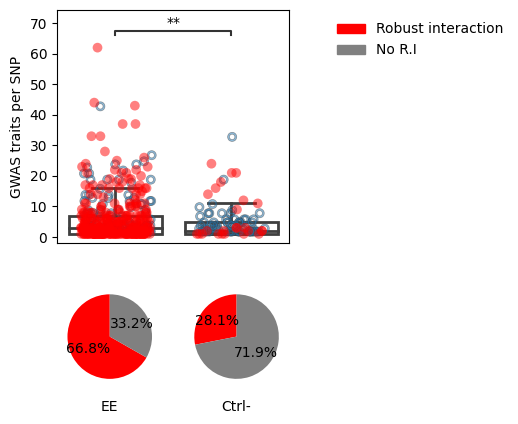

In [80]:
#============================================================
# Create one figure with GridSpec (2 rows, 2 columns)
#============================================================
fig = plt.figure(figsize=(3, 5))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[2, 1])

#------------------------------------------------------------
# TOP SUBPLOT (spans both columns) - the strip + box plot
#------------------------------------------------------------
ax_top = fig.add_subplot(gs[0, :])  # first row, spanning both columns

# ---- PLOT 1 Code ----
sns.stripplot(
    x='Dataset',
    y='#traits',
    data=combined_data[combined_data['Interactions'] == 'Not robust'],
    hue='Interactions',
    jitter=0.3,  # Add jitter to scatter points
    size=10,     # Adjust point size
    marker="$\circ$", ec="face",
    linewidth=0.5,  # Set border thickness
    alpha=0.5,   # Set transparency
    ax=ax_top,
    legend=False
)

sns.stripplot(
    x='Dataset',
    y='#traits',
    data=combined_data[combined_data['Interactions'] == 'Robust'],
    hue='Interactions',
    palette=["red"],
    edgecolor=None,
    jitter=0.3,
    size=7,
    alpha=0.5,
    ax=ax_top,
    legend=False
)

box_ax = sns.boxplot(
    x='Dataset',
    y='#traits',
    data=combined_data,
    showfliers=False,
    order=["E.E", "Ctrl-"],
    boxprops=dict(facecolor='none'),
    linewidth=2,
    ax=ax_top
)

# Add stat annotation
add_stat_annotation(box_ax, 
                    data=combined_data, 
                    x='Dataset', 
                    y='#traits',
                    box_pairs=[("E.E", "Ctrl-")],
                    pvalues=[0.0025],
                    test=None,
                    perform_stat_test=False,
                    text_format='star', 
                    loc='inside', 
                    verbose=2)

ax_top.set_xlabel(None)
ax_top.set_xticks([])
ax_top.set_xticklabels([])
ax_top.set_ylabel('GWAS traits per SNP')

#------------------------------------------------------------
# BOTTOM SUBPLOTS - the two pie charts side-by-side
#------------------------------------------------------------
ax_bottom_left = fig.add_subplot(gs[1, 0])  # second row, first column
ax_bottom_right = fig.add_subplot(gs[1, 1]) # second row, second column

# ---- PLOT 2 Code ----
# Pie chart 1
data1 = [66.76, 100-66.76]
colors1 = ['red', 'gray']
ax_bottom_left.pie(
    data1,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors1
)

# Pie chart 2
data2 = [28.09, 100-28.09]
colors2 = ['red', 'gray']
ax_bottom_right.pie(
    data2,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors2
)

ax_bottom_left.text(
    0.5,                # x-position in axes fraction
    -0.1,               # y-position in axes fraction (below the plot area)
    "EE",           # your text
    transform=ax_bottom_left.transAxes,  # coordinate system = axes
    ha='center',        # center horizontally
    va='top'            # top alignment (so that the text flows upward)
)

ax_bottom_right.text(
    0.5,                # x-position in axes fraction
    -0.1,               # y-position in axes fraction (below the plot area)
    "Ctrl-",           # your text
    transform=ax_bottom_right.transAxes,  # coordinate system = axes
    ha='center',        # center horizontally
    va='top'            # top alignment (so that the text flows upward)
)

## legend
import matplotlib.patches as mpatches
patch_robust = mpatches.Patch(color='red', label='Robust')
patch_other  = mpatches.Patch(color='gray', label='Other')

ax_top.legend([patch_robust,patch_other], ["Robust interaction","No R.I"], bbox_to_anchor=(1.15, 1), frameon=False)



# Adjust layout
plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/supplementary_figures/supp_fig7/gwas_watanabe.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/tls1/supplementary_figures/supp_fig7/gwas_watanabe.png", format="png", bbox_inches="tight", dpi=450)

plt.show()
